# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

In [30]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [158]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [159]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

In [160]:

        # create an hdf5 file
train_size = 5 #len(train_lines)
image = {}
box = {}
train_logits = {}
model_logits = {}

print( "total "+ str(len(train_lines)) + " loop "+ str( train_size ) )

i = 0 #step
for  img,box_data,flogits,mlogits in data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model) : 
    #x , y = dat
    image[i] = img
    box[i] = box_data
    train_logits[i] = flogits
    model_logits[i] = mlogits

    i+=1
    if i>= train_size:#(len(train_lines)) :
        break

total 2501 loop 5


In [161]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [162]:
ch = 1
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [163]:
box[ch]

array([[[112., 146., 257., 345.,   7.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

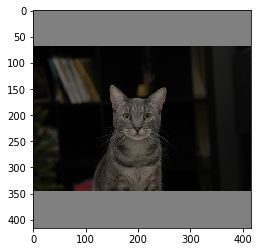

In [164]:
plt.imshow(image[ch][0])
plt.show()

In [165]:
train_logits[ch][0].shape

(1, 13, 13, 3, 25)

In [166]:
train_logits[ch][1].shape

(1, 26, 26, 3, 25)

In [167]:
train_logits[ch][2].shape

(1, 52, 52, 3, 25)

In [168]:
np.set_printoptions(threshold=np.inf)

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [169]:
lrg = train_logits[ch][0]
med = train_logits[ch][1]
sml = train_logits[ch][2]

In [170]:
lrgm = model_logits[ch][0]
medm = model_logits[ch][1]
smlm = model_logits[ch][2]

Change the Variable to see other scale

In [171]:
arrpl = lrg
arrpl[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxl = np.where(arrpl[:,:,:,:,4] > 0 )
boxl

(array([0], dtype=int64),
 array([7], dtype=int64),
 array([5], dtype=int64),
 array([1], dtype=int64))

x,y,w,h,p and class

In [172]:
box = boxl
arrp= arrpl
for i in range(len(box[0])):
    s = np.array(box)
    #print( i*5 )
    stp = i
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

(0,7,5,1)
[0.44230768 0.5889423  0.34855768 0.4783654  1.        ]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7 = cat
-------------------------------------------------------


In [173]:
arrpm = med
boxm = np.where(arrpm[:,:,:,:,4] > 0 )
boxm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [174]:
box = boxm
arrp= arrpm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

In [175]:
arrps = sml
boxs = np.where(arrps[:,:,:,:,4] > 0 )
boxs

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [176]:
box = boxs
arrp= arrps
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

### Model Predict

In [177]:
import math
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

def sigmoid(x):
        """sigmoid.

        # Arguments
            x: Tensor.

        # Returns
            numpy ndarray.
        """
        return 1 / (1 + np.exp(-x))
    

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

Change the Variable to see other scale

In [178]:
arrplm = lrgm
arrplm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxlm = np.where(arrplm[:,:,:,:,4] > 0 )
boxlm

(array([0, 0], dtype=int64),
 array([7, 7], dtype=int64),
 array([5, 6], dtype=int64),
 array([1, 1], dtype=int64))

x,y,w,h,p and class

In [179]:
from keras import backend as K

box = boxlm
arrp= arrplm
for i in range(len(box[0])  ):
    s = np.array(box)
    #print( i*5 )
    stp = i
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
    print( objprob )
    print( softmax(objprob) )
    obnum =  np.argmax( objprob ) 
    objsum = sum(objprob)
    #print(sum(softmax(objprob)))
    #print("sigmoid")
    #box_confidence = sigmoid( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp], 4:5])
    #box_class_probs = sigmoid(arrp[ s[0,stp],s[1,stp],s[2,stp],s[3,stp], 5:])
    #print( "conf = {} prob > {}".format( box_confidence , box_class_probs ))
    #print("--------------------------")
    print( "{} = {} sum > {}".format(obnum, obj[ obnum ],objsum ) )
    print("-------------------------------------------------------")

(0,7,5,1)
[ 1.1962415   0.02494862 -0.00771184  0.03409169  6.8841    ]
[-12.240032  -10.7923355 -10.254364  -17.57546    -9.352302  -12.874285
 -17.415346    6.8601475 -11.757622  -12.317841  -11.703533   -8.3856325
 -10.520541  -11.14591   -10.200705   -7.7736697 -11.321306  -15.123522
 -11.475943   -9.020238 ]
[5.0687037e-09 2.1558749e-08 3.6919992e-08 2.4420237e-11 9.0996011e-08
 2.6880942e-09 2.8660687e-11 9.9999893e-01 8.2111704e-09 4.6892690e-09
 8.6675325e-09 2.3924420e-07 2.8291915e-08 1.5137983e-08 3.8955214e-08
 4.4117760e-07 1.2702655e-08 2.8353930e-10 1.0882704e-08 1.2683402e-07]
7 = cat sum > -214.39043951034546
-------------------------------------------------------
(0,7,6,1)
[-2.3366547  -0.2128654  -0.0364522   0.01927548  5.661024  ]
[-12.275349 -10.497539  -9.686341 -16.432032  -9.474162 -13.226472
 -16.682425   6.351089 -11.892245 -11.817307 -12.244535  -7.795852
 -11.853113 -11.337633  -9.747341  -8.06773  -10.448847 -15.592499
 -12.81216   -8.852104]
[8.14029200e-

In [180]:
arrpmm = medm
arrpmm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxmm = np.where(arrpmm[:,:,:,:,4] > 0 )
boxmm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [181]:
box = boxmm
arrp= arrpmm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
 
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

In [182]:
arrpsm = smlm
arrpsm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxsm = np.where(arrpsm[:,:,:,:,4] > 0 )
boxsm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [183]:
box = boxsm
arrp= arrpsm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

Adjust the Model

In [184]:
lrga = model_logits[ch][0]
meda = model_logits[ch][1]
smla = model_logits[ch][2]

In [185]:
arrpa = lrga
arrpa[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
#boxa = np.where(arrpa[:,:,:,:,4] > 0 )
#boxa
arrpa[...,:2]

array([[[[[ 1.22564566e+00, -6.08614087e-01],
          [ 7.28169084e-01,  1.50660262e-01],
          [ 1.26906991e+00, -1.75771582e+00]],

         [[ 5.06162763e-01,  7.65147865e-01],
          [ 6.24058723e-01, -4.79973048e-01],
          [ 5.40365994e-01, -1.12731552e+00]],

         [[ 3.86742018e-02,  8.35980117e-01],
          [-5.49884558e-01,  4.34839785e-01],
          [ 1.03497386e+00, -1.52622998e-01]],

         [[ 1.29027456e-01,  4.16538984e-01],
          [-2.09082872e-01,  2.31987789e-01],
          [ 9.23026681e-01, -2.26386227e-02]],

         [[-4.32563394e-01,  3.97592753e-01],
          [-4.06971842e-01,  4.63900238e-01],
          [ 2.92055339e-01,  1.18503898e-01]],

         [[-1.56358942e-01,  2.24398911e-01],
          [-2.45444745e-01,  6.49383307e-01],
          [ 2.40064308e-01,  3.38386238e-01]],

         [[-4.69747096e-01,  3.79223049e-01],
          [-5.04981041e-01,  7.26008713e-01],
          [-1.74864680e-01,  4.52479273e-01]],

         [[-6.627715

In [186]:
box_xy = sigmoid(arrpa[...,:2])
box_xy

array([[[[[0.77305555, 0.35237542],
          [0.67440337, 0.53759396],
          [0.7805835 , 0.14707665]],

         [[0.62390655, 0.6824703 ],
          [0.6511411 , 0.3822585 ],
          [0.63189757, 0.24465685]],

         [[0.50966734, 0.6976179 ],
          [0.3658912 , 0.6070287 ],
          [0.73787904, 0.46191815]],

         [[0.5322122 , 0.60265476],
          [0.44791883, 0.5577382 ],
          [0.7156584 , 0.4943406 ]],

         [[0.3935144 , 0.5981092 ],
          [0.39963847, 0.61393905],
          [0.5724992 , 0.5295914 ]],

         [[0.46098974, 0.5558655 ],
          [0.43894503, 0.6568715 ],
          [0.5597295 , 0.58379847]],

         [[0.3846761 , 0.5936857 ],
          [0.37637082, 0.6739288 ],
          [0.4563949 , 0.6112285 ]],

         [[0.3401173 , 0.607285  ],
          [0.37372676, 0.67064404],
          [0.47171888, 0.5955664 ]],

         [[0.3325751 , 0.7103179 ],
          [0.3847803 , 0.66060466],
          [0.37627342, 0.4981923 ]],

         [

In [187]:
arrpa[..., 2:4]

array([[[[[-8.57055932e-02,  1.78694442e-01],
          [-2.37792477e-01,  2.68836766e-01],
          [ 7.58309811e-02, -1.07561825e-02]],

         [[ 1.60098001e-01,  2.06038356e-01],
          [-1.46560997e-01,  4.97778505e-01],
          [-2.67812997e-01,  4.49410491e-02]],

         [[ 2.21508294e-01, -1.17921859e-01],
          [-8.10392015e-03,  2.91657448e-01],
          [-5.20936847e-02, -3.66610408e-01]],

         [[ 3.83875817e-01,  1.63636468e-02],
          [ 8.93206298e-02,  2.47794315e-01],
          [-4.12589684e-02, -2.40186825e-01]],

         [[ 5.95626235e-01,  2.22198591e-01],
          [ 1.93088576e-01,  2.63676792e-01],
          [ 6.09547086e-03, -3.39916408e-01]],

         [[ 7.11503208e-01,  1.20091379e-01],
          [ 3.07372093e-01,  2.09833756e-01],
          [ 6.99813515e-02, -3.47701728e-01]],

         [[ 7.64326811e-01,  1.74446359e-01],
          [ 2.96547800e-01,  1.78466186e-01],
          [-1.97048672e-03, -4.15199816e-01]],

         [[ 8.362863

In [188]:
box_wh = np.exp(arrpa[..., 2:4])
box_wh

array([[[[[0.91786444, 1.1956553 ],
          [0.78836626, 1.3084415 ],
          [1.0787802 , 0.98930144]],

         [[1.1736258 , 1.2288003 ],
          [0.86367303, 1.6450627 ],
          [0.7650508 , 1.0459661 ]],

         [[1.2479576 , 0.8887655 ],
          [0.9919288 , 1.3386444 ],
          [0.9492399 , 0.6930796 ]],

         [[1.4679631 , 1.0164982 ],
          [1.0934312 , 1.2811964 ],
          [0.9595806 , 0.7864809 ]],

         [[1.8141667 , 1.2488194 ],
          [1.2129903 , 1.3017074 ],
          [1.0061141 , 0.71182984]],

         [[2.037051  , 1.1275998 ],
          [1.3598468 , 1.233473  ],
          [1.0724882 , 0.7063095 ]],

         [[2.1475482 , 1.1905869 ],
          [1.3452069 , 1.1953825 ],
          [0.99803144, 0.66020834]],

         [[2.3077807 , 1.3501126 ],
          [1.3436801 , 1.1500113 ],
          [1.0501114 , 0.7216613 ]],

         [[2.2460194 , 1.2946066 ],
          [1.3731418 , 1.1427292 ],
          [0.919593  , 0.7878033 ]],

         [

In [189]:
arrpa[..., 4]

array([[[[-11.324527  , -12.470285  , -15.194338  ],
         [-12.8168    , -13.226697  , -14.374426  ],
         [-12.133093  , -12.910695  , -13.926049  ],
         [-13.236296  , -14.024917  , -15.432627  ],
         [-14.261036  , -15.080116  , -15.08568   ],
         [-13.660175  , -14.891473  , -14.325178  ],
         [-12.775746  , -13.939521  , -13.504925  ],
         [-12.403444  , -13.941316  , -13.240473  ],
         [-12.500645  , -12.945168  , -14.615248  ],
         [-14.243903  , -13.589716  , -14.816477  ],
         [-11.537303  , -13.245128  , -12.461339  ],
         [-10.760549  , -10.992048  , -10.912148  ],
         [-10.663967  , -10.565445  , -10.743359  ]],

        [[-11.506717  , -12.608045  , -13.308699  ],
         [-12.085231  , -13.860047  , -14.421715  ],
         [-12.384718  , -12.938516  , -13.667099  ],
         [-13.610789  , -13.175034  , -14.978616  ],
         [-13.99548   , -13.351731  , -13.847294  ],
         [-13.060577  , -12.602394  , -12.07

In [190]:
box_confidence = sigmoid(arrpa[..., 4])
#box_confidence = np.expand_dims(box_confidence, axis=-1)
box_confidence

array([[[[1.20730010e-05, 3.83903580e-06, 2.51873701e-07],
         [2.71477120e-06, 1.80184622e-06, 5.71828650e-07],
         [5.37851520e-06, 2.47146977e-06, 8.95350922e-07],
         [1.78463358e-06, 8.11065092e-07, 1.98470190e-07],
         [6.40487258e-07, 2.82350527e-07, 2.80783951e-07],
         [1.16804813e-06, 3.40969365e-07, 6.00694875e-07],
         [2.82854194e-06, 8.83369978e-07, 1.36422216e-06],
         [4.10441044e-06, 8.81785923e-07, 1.77719448e-06],
         [3.72423733e-06, 2.38772395e-06, 4.49446901e-07],
         [6.51555126e-07, 1.25331655e-06, 3.67523995e-07],
         [9.75907733e-06, 1.76894116e-06, 3.87353566e-06],
         [2.12199284e-05, 1.68347542e-05, 1.82350177e-05],
         [2.33715637e-05, 2.57913671e-05, 2.15878426e-05]],

        [[1.00621792e-05, 3.34498645e-06, 1.65998779e-06],
         [5.64219999e-06, 9.56439521e-07, 5.45416924e-07],
         [4.18199534e-06, 2.40365989e-06, 1.15998887e-06],
         [1.22718143e-06, 1.89738205e-06, 3.12514175e-

In [191]:
arrpa[..., 5:]

array([[[[[-1.23894186e+01, -7.11667633e+00, -1.24149551e+01,
           -1.30242987e+01, -9.96545696e+00, -7.48271084e+00,
           -1.01660376e+01, -1.00728149e+01, -2.35981822e+00,
           -1.01212711e+01, -1.12808666e+01, -1.21880779e+01,
           -9.58964729e+00, -1.03973093e+01, -4.31969929e+00,
           -1.05743885e+01, -9.89186192e+00, -1.11792622e+01,
           -1.12707148e+01, -6.33002329e+00],
          [-1.00734577e+01, -6.46516085e+00, -9.59888649e+00,
           -1.34177408e+01, -7.76782799e+00, -9.42304802e+00,
           -1.11478415e+01, -1.06376085e+01, -4.49895716e+00,
           -1.16984949e+01, -9.82515049e+00, -1.07843056e+01,
           -1.28007193e+01, -1.14050264e+01, -1.00132775e+00,
           -1.18930664e+01, -1.27908258e+01, -7.99031353e+00,
           -1.00622511e+01, -8.66489887e+00],
          [-8.65089417e+00, -4.67942142e+00, -8.82850647e+00,
           -8.06055927e+00, -8.77449322e+00, -5.48730373e+00,
           -4.73939419e+00, -8.32356262e

In [192]:
box_class_probs = sigmoid(arrpa[..., 5:])
box_class_probs

array([[[[[4.16238299e-06, 8.10801401e-04, 4.05743640e-06,
           2.20606353e-06, 4.69933730e-05, 5.62413421e-04,
           3.84529158e-05, 4.22098419e-05, 8.62885267e-02,
           4.02133555e-05, 1.26117802e-05, 5.09076199e-06,
           6.84288680e-05, 3.05135472e-05, 1.31292138e-02,
           2.55617342e-05, 5.05821154e-05, 1.39605354e-05,
           1.27404637e-05, 1.77882239e-03],
          [4.21827172e-05, 1.55432115e-03, 6.77995995e-05,
           1.48849904e-06, 4.22952347e-04, 8.08327095e-05,
           1.44061423e-05, 2.39957808e-05, 1.09982798e-02,
           8.30624231e-06, 5.40714318e-05, 2.07217581e-05,
           2.75878006e-06, 1.11392292e-05, 2.68680453e-01,
           6.83760391e-06, 2.78620928e-06, 3.38613172e-04,
           4.26580846e-05, 1.72507236e-04],
          [1.74939720e-04, 9.19897668e-03, 1.46475417e-04,
           3.15650512e-04, 1.54603345e-04, 4.12192801e-03,
           8.66814796e-03, 2.42670678e-04, 4.45425336e-04,
           2.14699339e-05, 

In [193]:
newa = arrpa
newa[...,:2] = box_xy 
newa[..., 2:4] = box_wh
newa[..., 4] = box_confidence
newa[..., 5:] = box_class_probs

newa


array([[[[[7.73055553e-01, 3.52375418e-01, 9.17864442e-01,
           1.19565535e+00, 1.20730010e-05, 4.16238299e-06,
           8.10801401e-04, 4.05743640e-06, 2.20606353e-06,
           4.69933730e-05, 5.62413421e-04, 3.84529158e-05,
           4.22098419e-05, 8.62885267e-02, 4.02133555e-05,
           1.26117802e-05, 5.09076199e-06, 6.84288680e-05,
           3.05135472e-05, 1.31292138e-02, 2.55617342e-05,
           5.05821154e-05, 1.39605354e-05, 1.27404637e-05,
           1.77882239e-03],
          [6.74403369e-01, 5.37593961e-01, 7.88366258e-01,
           1.30844152e+00, 3.83903580e-06, 4.21827172e-05,
           1.55432115e-03, 6.77995995e-05, 1.48849904e-06,
           4.22952347e-04, 8.08327095e-05, 1.44061423e-05,
           2.39957808e-05, 1.09982798e-02, 8.30624231e-06,
           5.40714318e-05, 2.07217581e-05, 2.75878006e-06,
           1.11392292e-05, 2.68680453e-01, 6.83760391e-06,
           2.78620928e-06, 3.38613172e-04, 4.26580846e-05,
           1.72507236e-04],


In [194]:
arrpan = newa
arrpan[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxan = np.where(arrpan[:,:,:,:,4] > 0.3 )
boxan

(array([0, 0, 0], dtype=int64),
 array([6, 7, 7], dtype=int64),
 array([5, 5, 6], dtype=int64),
 array([1, 1, 1], dtype=int64))

In [195]:
box = boxan
arrp= arrpan
for i in range(len(box[0])  ):
    s = np.array(box)
    #print( i*5 )
    stp = i
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
    print( objprob )
    obnum =  np.argmax( objprob ) 
    print( "{} = {} sum ".format(obnum, obj[ obnum ]) )
    print("-------------------------------------------------------")

(0,6,5,1)
[0.7628942  0.8144036  0.9682527  0.96772027 0.32968682]
[1.0768749e-04 6.9724524e-04 1.5084217e-04 4.0862705e-07 1.6889980e-03
 1.8639905e-05 1.1470848e-06 9.9023318e-01 6.2298233e-04 2.7515243e-05
 1.3716983e-04 2.0625052e-04 1.6034704e-05 5.7344434e-05 3.7890259e-04
 5.3847744e-03 4.9777591e-04 4.2308429e-06 3.2750124e-04 2.1810804e-03]
7 = cat sum 
-------------------------------------------------------
(0,7,5,1)
[0.7678555  0.50623685 0.9923178  1.0346795  0.9989772 ]
[4.8330298e-06 2.0556032e-05 3.5202298e-05 2.3284908e-08 8.6757966e-05
 2.5631150e-06 2.7328216e-08 9.9895227e-01 7.8293615e-06 4.4712388e-06
 8.2644992e-06 2.2806940e-04 2.6975860e-05 1.4433990e-05 3.7142760e-05
 4.2048981e-04 1.2111946e-05 2.7035713e-07 1.0376644e-05 1.2092273e-04]
7 = cat sum 
-------------------------------------------------------
(0,7,6,1)
[0.08813239 0.4469837  0.9642042  1.0194625  0.99653304]
[4.6653240e-06 2.7603552e-05 6.2122432e-05 7.3056576e-08 7.6805147e-05
 1.8022517e-06 5.687